# MNIST en Keras con Convnets

Basado en el capítulo 5 del libro "Deep Learning with Python" de Francois Chollet, 2018 Manning

Se va a utilizar el dataset de imágenes de dígitos MNIST. Con el modelo de 2 capas escondidas con redes neuronales tradicionales, obtuvimos 98% de accuracy en set de test.

## Obtención y preparación del dataset

Los datasets serán representados como tensores.
El tensor de entrada a la red tendra rango 4: número de imágenes, alto de la imagen, anchon de la imagen y canales de color.

Por ejemplo, En el caso del del tensor de entrenamiento (train_images) tenemos el primer rango de 60000 dimensiones, pues hay 60000 imágenes. Los 2 siguientes rangos son los que dan el tamaño de las imágenes (de 28 dimensiones cada uno). Como son imágenes en escala de grises, el 4o rango que tendría el canal de color (e.g. RGB) tendrá solo una dimensión. Cada valor de la matriz de 28x28 es una valor en escal de grises de 0 a 255.

Necesitamos que los datos de entrenamiento y test estén en el formato dado por la capa de entrada de la red que vamos a definir.

In [1]:
import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Using TensorFlow backend.


In [2]:
train_images.shape

(60000, 28, 28)

Tenemos que agregar el cuarto eje al tensor (con una sola dimensión, con el único canal de color).
Vamos además a modificar la escalas de grises con valores en una escala que vaya de 0 a 1 y que sean entonces de tipo flotantes.

Finalmente, convertimos los labels de arrays one hot encoded.

In [3]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

train_labels[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

## Definición del modelo

Vamos a definir un modelo secuencial:
* que recibe un tensor con las instancias de imágen con tres ejes con la dimensionalidad (28, 28, 1), 
* con 3 capas convolucionales 2D, la primera con 32 filtros de 3x3 utilizando una función de activación RELU, y la segunda con 64 filtros,
* con capas intermedias de pooling que toman las salidas de las capas convolucionales, calculando el MAX de los valores de ventanas de 2x2.

In [11]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


- **Expliquen el número de parámetros de cada capa**

### Modelos con capas convolucionales

La diferencia entre un modelo convolucional y uno fully connected es que el fully connected aprende patrones globales, mientras que el convolucional aprende patrones locales, lo cual es muy importante en el caso del análisis de imágenes, presentando 2 características muy importantes:
* los patrones aprendidos son invariantes a la traslación: una capa convolucional puede reconocer el patrón independientemente de dónde se encuentre en la imagen, uno fully connected necesitaría una red dependiente del lugar donde esté el mismo patrón en dos imágenes diferentes.
* se puede reconocer una jerarquía espacial entre los patrones aprendidos: las primeras capas convolucionales aprenden a un mayor nivel de abstracción, que se va especializando a medida que las capas son más profundas. Las abstracciones de las primeras capas son los bloques que componen los patrones de las siguientes capas, todo sucesivamente, hasta llegar a la última capa con mayor complejidad en las representaciones que puede aprender.

Las convoluciones en imágenes operan sobre tensores de 3D llamados **feature maps**, con dos ejes espaciales (ancho, alto) y uno de profundidad (los canales). Las imágenes del MNIST solo tenían los ejes espaciales, es por esto que se tuvo que agregar el tercer eje.

Los filtros de las convoluciones van aplicándose a ventanas de las imágenes de entrada, produciendo **feature maps** de salida, donde la profundidad (el eje de canales) está dada por el número de filtros en cada capa. Cada filtro produce la imágen de un canal. Esto también aplica para imágenes de entrada con múltiples canales: si fueran RGB, cada filtro produce al final un feature map de un solo canal.

Cada filtro se aplica a los diferentes canales de entrada. En la primera capa convolucional se reciben imágenes de 28x28x3, se consideran entonces 26x26 ventanas (dado el padding 'valid', ver en la subsección siguiente), por cada uno de los canales RGB. Así, un filtro aplicado va a producir 3 imágenes de 26x26 que se deben agregar en una sola; el promedio de las 3 imágenes creadas por un filtro va a dar la imagen 26x26 del canal de salida correspondiente al filtro en cuestión.

En Keras, una capa convolucional se especifica con 2 parámetros principales: la profundidad (número de filtros), y el tamaño del filtro (alto, ancho) que se va a desplazar a cada ventana de los inputs 2D.

### Pooling

Las capas convolucionales son a menudo seguidas de capas de **pooling** que permiten reducir la dimensionalidad (y el número de parámetros de los pesos de capas convolucionales subsecuentes. Las capas de pooling consisten en ventanas que se deslizan sobre las imágenes de entrada para resumir los datos. La función de agregación más usada es el **max**, pero tambien es posible usar poolings con **average**.

Por defecto, las ventanas tienen un stride correspondiente al tamaño de las mismas, de tal modo que se divide el tamaño de las imágenes de entrada por el tamaño de la ventana del pooling para dar una representación de salida con dimensiones reducidas. Con ventanas de 2x2 (las mas usuales), el pooling termina reduciendo las imágenes a la mitad.

Las capas de pooling, y la reducción de las imágenes son necesarias porque, por un lado, esto permite que las capas mas profundas tengan una visión mayor, cada vez menos localizada de las capas superiores, uno de los objetivos es aprender la jerarquía espacial de los patrones detectados; las convoluciones sucesivas tienen una visión cada vez más grande de los datos.
Por otro lado, el número de valores de la última capa convolucional debe reducirse, teniendo en cuenta la conexión con las capas densas finales, y no tener millones de parámetros y los problemas que ello genera (tiempo y espacio durante el entrenamiento, overfitting).

La reducción de los datos también se pudo haber logrado utilizando strides, o utilizar un promedio de los datos agregados, pero en la aplicación, max pooling tiende a funcionar mejor.

### Padding, strides y número de parámetros

Las capas convolucionales y de pooling tienen como argumento el tipo de **padding** a utilizar, que consiste en la configuración a seguir cuando se estén tratando los pixeles que se encuentren en los extremos de las imágenes. Existen 2 tipos:
* '**valid**': que no agrega pixeles en los extremos de las imágenes, teniendo como resultado imágenes de salida con un tamaño inferior al de la entrada. El qué tan inferior depende del tamaño del filtro. Con un padding 'valid' y con filtros 3x3, se reduce en 2 pixeles el alto y ancho de las imágenes; con filtros 5x5, se reducen en 4 pixeles; con filtros 7x7 se reducen en 6 pixeles. Este es el valor por defecto en las capas convolucionales y de pooling.
* '**same**': que agrega los pixeles que sean necesarios en los extremos de las imágenes para que las imágenes de salida tengan el mismo alto y ancho que las de entrada.

En cuanto al **stride** a utilizar, que especifica los saltos que se deben tomar en cada ventana de análisis:
* en el caso de las convoluciones, el stride por defecto es de (1, 1), es decir, los filtros se aplican en ventanas que se mueven de a 1 pixel en el eje del alto y de a 1 pixel en el eje del ancho.
* en el caso del pooling, el stride por defecto es igual al tamaño de la ventana (*pool_size*), de tal manera que las ventanas de análisis no se sobreponen nunca.

La primera capa del modelo tiene como entrada tensores de dimensionalidad (28, 28, 1). Por cada filtro aplicado, se tiene una salida resultado de la convolución. Como el padding es 'valid' por defecto y los filtros son de tamaño 3x3, los tensores de salida tienen una dimensionalidad de (26, 26, 32). 
Esta salida pasa por una capa de maxpooling (2, 2), que reduce entonces el tamaño en 2, con tensores de salida de tipo (13, 13, 32).

La segunda capa del modelo tiene como entrada tensores de dimensionalidad (13, 13, 32). Por cada filtro aplicado, se tiene una salida resultado de la convolución. Como el padding es 'valid' por defecto y los filtros son de tamaño 3x3, los tensores de salida tienen una dimensionalidad de (11, 11, 64).
La segunda capa de maxpooling recibe entonces tensores tipo (11, 11, 64). Como las dimensiones de las imágenes no son divisibles por 2, la última fila y última columna no son consideradas y se desechan, dando tensores de salida de tipo (5, 5, 64). 

La tercera capa de convolución produce una salida con tensores (3, 3, 64). Después de esta capa no hay capa de pooling.

El número total de parámetros del modelo convolucional es de 55744:
* Cada capa convolucional aporta un parámetro por cada pixel de su filtro (en este caso 3x3=9) multiplicado por la profundidad del input (la capa inicial tiene un solo canal de color) y uno del bias por cada filtro. Así, la primera capa convolucional tiene (3x3)x1x32 + 32= 320. La segunda capa tiene (3x3)x32x64 + 64 = 18496. La tercera capa tiene (3x3)x64x64+64 = 36928.
* Las capas de pooling no tienen parámetros.

Después de las capas convolucionales, vamos a aplanar el tensor de salida, pasando de (3, 3, 64) a (3x3x64) 576 neuronas . Se utiliza una capa tipo **Flatten**, que no tiene parámetros para realizar esta reorganización de los datos. Cabe anotar que no se pierde ninguna información, solo se reacomoda.

Este tensor 1D es luego usado como entrada de una primera capa **Dense**, una capa fully connected, de las tradicionales redes neuronales de perceptron multicapa, con 64 neuronas utilizando una función de activación RELU. Esto equivale a 576x64+64=36928 parámetros del modelo.

Una última capa fully connected de 10 neuronas permite realizar la clasificación final en cada uno de los 10 dígitos (64x10+10=650 parámetros adicionales). Cada una de estas neuronas representa una de las clases, de tal manera que los outputs reales representados con arrays one hot encoded de 10 posiciones van a ser comparados con los arrays de las 10 neuronas de salida. Esta última capa utiliza una función de activación **softmax** para poder realizar la clasificación multi clase.


In [12]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation='softmax'))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                36928     
__________

## Entrenamiento del modelo

El modelo final tiene en total 93332 parámetros. Lo compilamos utilizando un optimizador **rmsprop** y una función de activación **categorical_cross_entropy**, y lo entrenamos con 5 épocas con el set de entrenamiento ya procesado.

In [14]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 32s 592us/step - loss: 0.2390 - acc: 0.9264 - val_loss: 0.0568 - val_acc: 0.9832
Epoch 2/5
54000/54000 [==============================] - 33s 617us/step - loss: 0.0675 - acc: 0.9796 - val_loss: 0.0379 - val_acc: 0.9907
Epoch 3/5
54000/54000 [==============================] - 34s 623us/step - loss: 0.0477 - acc: 0.9862 - val_loss: 0.0409 - val_acc: 0.9887
Epoch 4/5
54000/54000 [==============================] - 32s 589us/step - loss: 0.0365 - acc: 0.9891 - val_loss: 0.0297 - val_acc: 0.9927
Epoch 5/5
54000/54000 [==============================] - 32s 592us/step - loss: 0.0300 - acc: 0.9913 - val_loss: 0.0318 - val_acc: 0.9927


## Evaluación de los resultados del modelo

In [15]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 2s 183us/step


In [16]:
test_acc

0.9911

Teniendo en cuenta el resultado obtenido con el modelo de red neuronal tradicional (98%), el modelo convolucional lo mejora, llegando a un nivel de exactitud de mas del 99% en tan solo 5 épocas, utilizando una capa de regularización a partir de dropout.

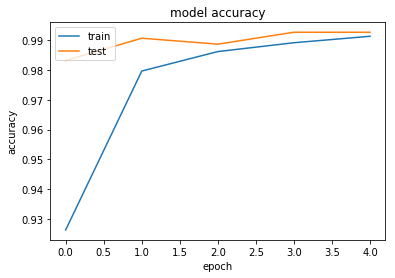

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

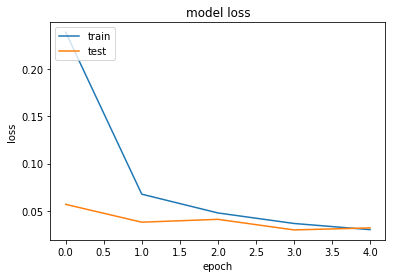

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()